# Notes - maternal age


In [2]:
import duckdb
import os
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
from chance import get_ds_lb_nt_probability_array
from graphviz import Digraph
from sympy.physics.units import magnetic_density

from variables import Variables as vars

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = 1971
np.random.seed(RANDOM_SEED)

In [3]:
con = duckdb.connect("./data/us_births.db", read_only=True)

In [4]:
MIN_YEAR = 2004
MAX_YEAR = 2024

In [5]:
counts_df = con.execute(
    f"""
        SELECT
            mage_c as age,
            SUM(down_ind) as count_ds_rec,
            COUNT(down_ind) as count_ds_obs,
            COUNT(*) as count_lb
        FROM
            us_births
        WHERE
            year >= {MIN_YEAR} AND year <= {MAX_YEAR}
        GROUP BY mage_c
        ORDER BY mage_c
        """
).df()
counts_df

,age,count_ds_rec,count_ds_obs,count_lb
0,12,0.0,1404,2005
1,13,1.0,8039,11693
2,14,9.0,42260,60446
3,15,71.0,149563,211879
4,16,134.0,361653,507849
5,17,272.0,684902,952137
6,18,428.0,1196329,1629132
7,19,666.0,1881738,2500245
8,20,821.0,2312348,3019523
9,21,892.0,2567643,3316281


Text(0, 0.5, 'DS live births recorded')

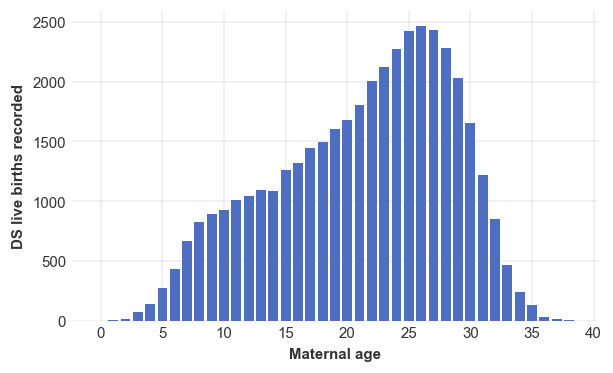

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(counts_df["age"], counts_df["count_ds_rec"])
ax.set_xlabel("Maternal age")
ax.set_ylabel("DS live births recorded")

Text(0, 0.5, 'Probability of DS recorded')

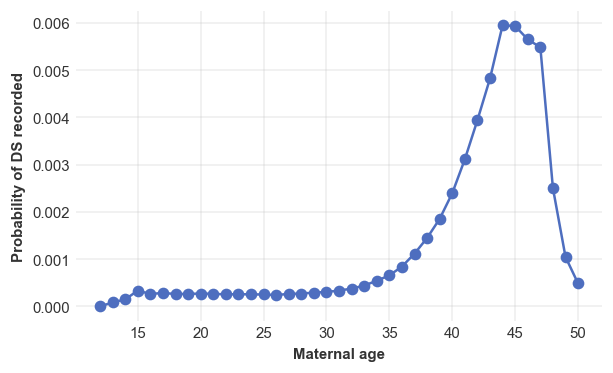

In [7]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(counts_df["age"], counts_df["count_ds_rec"] / counts_df["count_lb"], marker="o")
ax.set_xlabel("Maternal age")
ax.set_ylabel("Probability of DS recorded")

In [8]:
df = counts_df.sort_values("age").reset_index(drop=True)
age = df["age"].to_numpy()
y = df["count_ds_rec"].to_numpy().astype(int)
n = df["count_lb"].to_numpy().astype(int)

# standardize age (better geometry for MCMC)
age_mean, age_sd = age.mean(), age.std()
age_std = (age - age_mean) / age_sd
age_std2 = age_std**2

coords = {"obs": np.arange(len(df)), "coef": ["intercept", "age_std", "age_std2"]}

with pm.Model(coords=coords) as model:
    # Design matrix X: [1, age_std, age_std^2]
    X = pm.Data(
        "X", np.c_[np.ones_like(age_std), age_std, age_std2], dims=("obs", "coef")
    )

    # weakly-informative priors on logit scale
    beta = pm.Normal("beta", mu=0.0, sigma=2.0, dims="coef")

    eta = pm.Deterministic("eta", pt.sum(X * beta, axis=1), dims="obs")
    p = pm.Deterministic("p", pm.math.sigmoid(eta), dims="obs")

    y_obs = pm.Binomial("y_obs", n=n, p=p, observed=y, dims="obs")

    idata = pm.sample(
        draws=2000, tune=2000, chains=4, target_accept=0.9, random_seed=42
    )

c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 12 seconds.


In [9]:
az.summary(idata, var_names=["beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[intercept],-7.787,0.006,-7.799,-7.775,0.0,0.0,3967.0,4896.0,1.0
beta[age_std],1.316,0.008,1.301,1.332,0.0,0.0,5297.0,5500.0,1.0
beta[age_std2],0.707,0.010,0.688,0.724,0.0,0.0,3799.0,4456.0,1.0


array([<Axes: title={'center': 'beta\nintercept'}>,
       <Axes: title={'center': 'beta\nage_std'}>,
       <Axes: title={'center': 'beta\nage_std2'}>], dtype=object)

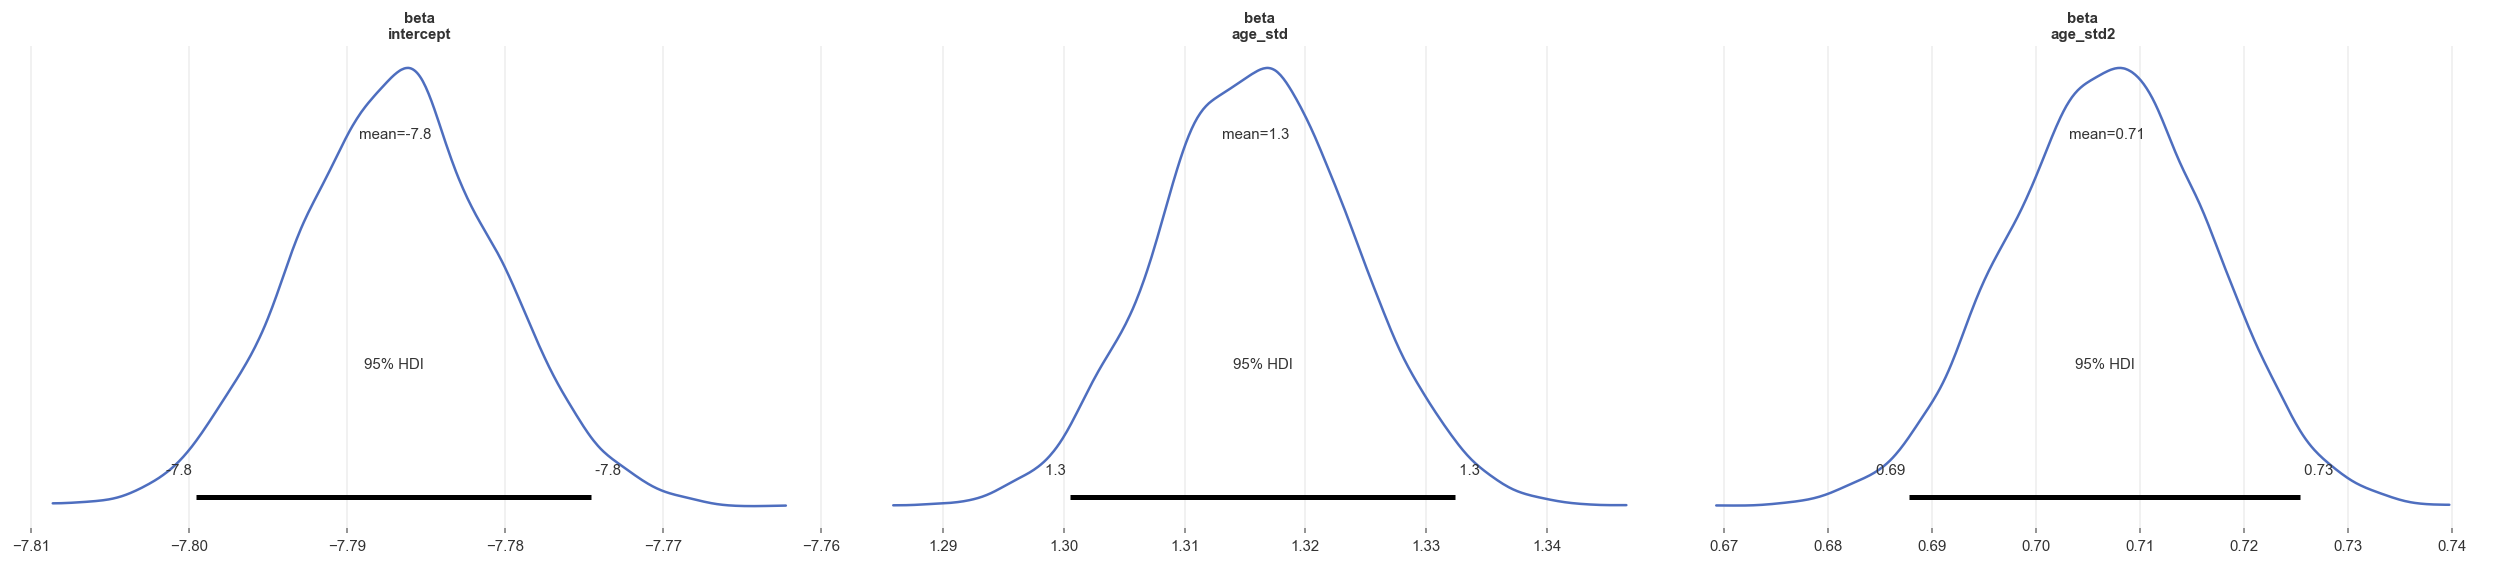

In [10]:
az.plot_posterior(idata, var_names=["beta"], hdi_prob=0.95)

In [11]:
idata.posterior

<xarray.Dataset> Size: 5MB
Dimensions:  (chain: 4, draw: 2000, coef: 3, obs: 39)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 16kB 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * coef     (coef) <U9 108B 'intercept' 'age_std' 'age_std2'
  * obs      (obs) int64 312B 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38
Data variables:
    beta     (chain, draw, coef) float64 192kB -7.787 1.31 ... 1.314 0.7132
    eta      (chain, draw, obs) float64 2MB -7.989 -8.078 ... -3.863 -3.537
    p        (chain, draw, obs) float64 2MB 0.0003392 0.0003102 ... 0.02826
Attributes:
    created_at:                 2025-11-09T16:28:48.970853+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.26.1
    sampling_time:              11.709181785583496
    tuning_steps:               2000

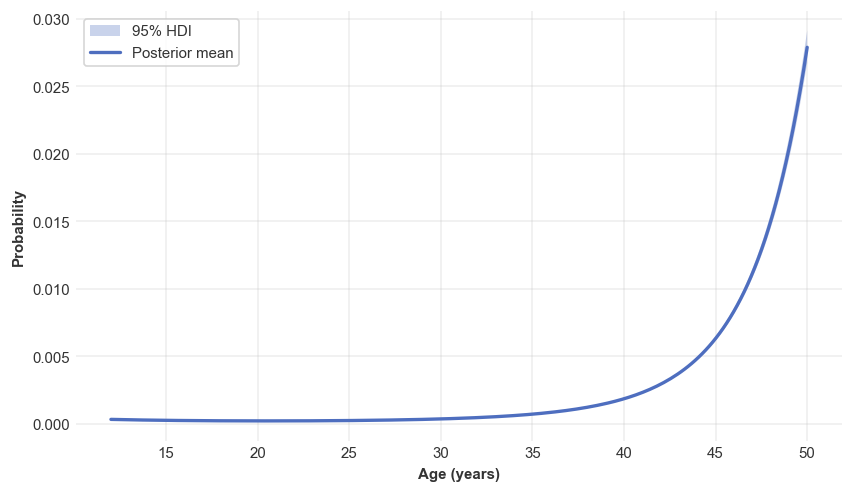

In [12]:
import numpy as np
import xarray as xr
import arviz as az
from scipy.special import expit
import matplotlib.pyplot as plt

# beta: dims (chain, draw, coef)
beta = idata.posterior["beta"]

age_grid = np.linspace(age.min(), age.max(), 200)
z = (age_grid - age_mean) / age_sd
Xg = np.c_[np.ones_like(z), z, z**2]  # shape (grid, coef)

Xg_da = xr.DataArray(
    Xg, dims=("grid", "coef"), coords={"grid": age_grid, "coef": beta.coords["coef"]}
)

# Broadcast multiply and sum over coef -> dims: (chain, draw, grid)
eta = (beta * Xg_da).sum("coef")
p = xr.apply_ufunc(expit, eta)

p_mean = p.mean(("chain", "draw"))
p_hdi  = az.hdi(p, hdi_prob=0.95)          # (grid, hdi) with coords hdi=['lower','higher']

age_grid = p.coords["grid"].values.astype(float)

# Force numeric dtype for Matplotlib

lower = p_hdi.sel(hdi="lower")["x"]
upper = p_hdi.sel(hdi="higher")["x"]
mean  = p_mean

# (Optional) clip to [0,1] for safety
lower = np.clip(lower, 0.0, 1.0)
upper = np.clip(upper, 0.0, 1.0)
mean  = np.clip(mean,  0.0, 1.0)

fig, ax = plt.subplots(figsize=(7, 4))
ax.fill_between(age_grid, lower, upper, alpha=0.3, label="95% HDI")
ax.plot(age_grid, mean, lw=2, label="Posterior mean")
ax.set_xlabel("Age (years)")
ax.set_ylabel("Probability")
ax.legend()